## Viscek Model

# Preliminary steps

First, I try to simulate the motion of only 1 particle within a square box of length L. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#input parameters
L = 10   #length of the box in micrometer
v0 = 2   #constant velocity in micrometer per second
Dt = 1   #time steps in seconds

#let the particle randomly appear within the box
startx = np.random.rand()*L
starty = np.random.rand()*L

#calculate new position after short time Delta t with polar coordinates
#calculate angle Theta first: here uniformly distributed over all directions
theta = np.random.rand()*2*np.pi  #in radians: 360 degrees= 2 pi rad
#calculate x and y position of particle after Dt
posx = v_0 * Dt * np.sin(theta)
posy = v_0 * Dt * np.cos(theta)

NameError: name 'v_0' is not defined

position of the particle: $$(x,y) = (r*cos(\Theta),r*sin(\Theta)$$

velocity of the particle: $$v(t) = v_0$$

position of the particle at all times: $$(x,y) = (v_0*t*cos(\Theta),v_0*t*sin(\Theta))$$

In [25]:
#input parameters
L = 10   #length of the box in micrometer
v_0 = 0.5   #constant velocity in micrometer per second
Dt = 1   #time steps in seconds

def viscekparticle(L,v_0,Dt):
    #dimensions of the box
    xmin = 0
    xmax = L
    ymin = 0
    ymax = L

    #let the particle randomly appear within the box
    startx = np.random.rand()*L
    starty = np.random.rand()*L

    #make a list with positions
    position = [[startx,starty]]
    #empty list for angles theta
    angles = []
    #counter for number of interactions
    counter = 0

    #check whether position of particle is within the box
    while xmin<position[-1][0]<xmax and ymin<position[-1][1]<ymax and counter<100:
        #calculate angle Theta first: here uniformly distributed over all directions
        theta = np.random.rand()*2*np.pi  #in radians: 360 degrees= 2 pi rad
        angles.append(theta)
        #calculate new position
        posx = v_0 * Dt * np.sin(theta)
        posy = v_0 * Dt * np.cos(theta)
        position.append([position[-1][0]+posx,position[-1][1]+posy])
    return position,angles

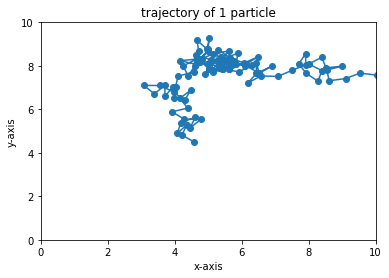

In [41]:
#figure
plt.plot(*np.asarray(viscekparticle(L,v_0,Dt)[0]).transpose(),"-o")
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('trajectory of 1 particle')
plt.show()

Now i try to simulate it for more than 1 particle, namely N particles:

In [29]:
#input parameters
L = 10   #length of the box in micrometer
v_0 = 0.5   #constant velocity in micrometer per second
Dt = 1   #time steps in seconds
N = 5   #number of particles
T = 150 #max time

def viscekparticles(N,T,L,v_0,Dt):
    #dimensions of the box
    xmin = 0
    xmax = L
    ymin = 0
    ymax = L
    #empty array for particle positions and angles
    data = np.empty([T,N,3],dtype=float)
    #let the particles randomly appear within the box with random starting angle
    data[0] = np.random.rand(N,3)*[xmax,ymax,2*np.pi]
    
    for t in np.arange(1,T):
        #save angles for further calculations
        theta = data[t-1,:,-1]
        step = np.transpose([v_0*Dt*np.sin(theta),v_0*Dt*np.cos(theta),np.random.rand(N)*2*np.pi-theta])
        #periodic boundary conditions: only works for L > 2*pi !!!
        data[t] = (data[t-1]+step)%L
    return data

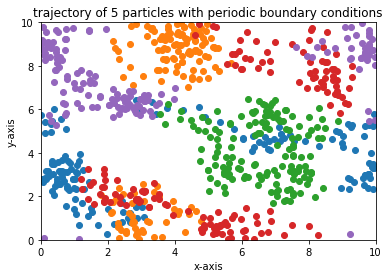

In [30]:
#figure
plt.plot(*np.transpose(viscekparticles(N,T,L,v_0,Dt)[:,:,:2], (2,0,1)),"o")
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('trajectory of {} particles with periodic boundary conditions'.format(N))
plt.show()

Now I add another particle to the box, so that we have in total 2 particles. 
I also add an interaction term to the behaviour of the particle, so that they feel each other. For that, we have to think about an environment around the particle. 
In 2 dimensions this environment would be a sphere of radius R and a centerpoint at the current position of the particle.
We check, if there is another particle at (x,y) in the surrounding of the particle at (center_x,center_y) with:
$$(x - center_x)^2 + (y - center_y)^2 < radius^2$$

When other particles are within the environment of the particle, the trajectory, or more precise the angle, of the particle changes: 

First we calculate the average angle of the particles in the neighbourhood with: 
$$\Theta_n(t) = \frac{1}{k_n(t)} \sum_j \Theta_j$$ with $k$ particles in the neighborhood of the particle and their velocities $v_j$

the new angle of the motion is: $$\Theta_{new} = \Theta_n + \eta*\xi$$
with $\eta$ as noise intensity and $\xi$ is a randomly distributed variable between $[-\pi,\pi]$

if there are not any other particles within the surrounding of the particle, the angle is generated by a random number generator (between 0 and 360 degrees)

In [117]:
#input parameters
L = 100   #length of the box in micrometer
v_0 = 0.5   #constant velocity in micrometer per second
Dt = 1   #time steps in seconds
N = 10   #number of particles
T = 1000 #max time
R = 2 # radius of surrounding in micrometer
eta = 0.2  #noise term

def viscekparticles(N,T,L,v_0,Dt,R,eta):
    #dimensions of the box
    xmin = 0
    xmax = L
    ymin = 0
    ymax = L
    #empty array for particle positions and angles
    data = np.empty([T,N,3],dtype=float)
    #let the particles randomly appear within the box with random starting angle
    data[0] = np.random.rand(N,3)*[xmax,ymax,2*np.pi]
    
    for t in np.arange(1,T):
        #save angles for further calculations
        theta = data[t-1,:,-1]
        new_theta = np.empty(N)
        #check how many particles are in the surrounding of the particle
        # datastructure: (time;particle;0-x,1-y,2-angle)
        #m = particle we are looking at
        for m in np.arange(1,N):
            influence = []
            #n = check all other particles if they are in the surrounding
            for n in np.arange(1,N):
                if ((data[t-1,n,0]-data[t-1,m,0])**2 + (data[t-1,n,1]-data[t-1,m,1])**2) < R**2:
                    #save thetas
                    influence.append(data[t-1,n,2])
                #calculate average of thetas
            new_theta[m] = np.mean(influence)+eta*(np.random.rand()*2*np.pi-np.pi)
        step = np.transpose([v_0*Dt*np.sin(new_theta),v_0*Dt*np.cos(new_theta),new_theta-theta])
        #periodic boundary conditions: only works for L > 2*pi !!!
        data[t] = (data[t-1]+step)%L
    return data

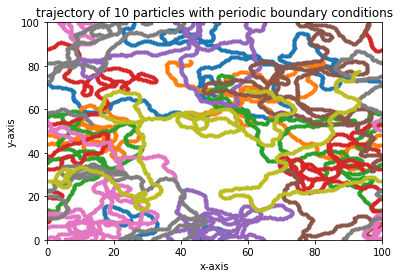

In [118]:
#figure
plt.plot(*np.transpose(viscekparticles(N,T,L,v_0,Dt,R,eta)[:,1:,:2], (2,0,1)),".")
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('trajectory of {} particles with periodic boundary conditions'.format(N))
plt.show()

I now correct the velocity of the particle. The velocity of the particle is not constant but rather depends on the direction is it moving to:
$$v(t+\Delta t) = v_0 * exp(i*\theta(t+\Delta t))$$

Furthermore should we adjust the parameters for molecular motors:
Speed of myosin is about 1.43 micrometer per second (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2269597/)

In [1]:
def veldistribution(theta):
    return (np.exp(1j*theta)).real

x = np.arange(-2*np.pi,2*np.pi,0.1)
plt.plot(x,veldistribution(x))
plt.show()

NameError: name 'np' is not defined

In [2]:
#input parameters
L = 100   #length of the box in micrometer
v_0 = 1.43   #constant velocity in micrometer per second
Dt = 0.1   #time steps in seconds
N = 100 #number of particles
T = 1000 #max time
R = 2 # radius of surrounding in micrometer
eta = 0.2  #noise term

def viscekparticles(N,T,L,v_0,Dt,R,eta):
    #dimensions of the box
    xmin = 0
    xmax = L
    ymin = 0
    ymax = L
    #empty array for particle positions and angles
    data = np.empty([T,N,3],dtype=float)
    #let the particles randomly appear within the box with random starting angle
    data[0] = np.random.rand(N,3)*[xmax,ymax,2*np.pi]
    
    for t in np.arange(1,T):
        #save angles for further calculations
        theta = data[t-1,:,-1]
        new_theta = np.empty(N)
        #check how many particles are in the surrounding of the particle
        # datastructure: (time;particle;0-x,1-y,2-angle)
        #m = particle we are looking at
        for m in np.arange(1,N):
            influence = []
            #n = check all other particles if they are in the surrounding
            for n in np.arange(1,N):
                if ((data[t-1,n,0]-data[t-1,m,0])**2 + (data[t-1,n,1]-data[t-1,m,1])**2) < R**2:
                    #save thetas
                    influence.append(data[t-1,n,2])
                #calculate average of thetas
            new_theta[m] = np.mean(influence)+eta*(np.random.rand()*2*np.pi-np.pi)
        #velocity of particle
        v = v_0 * (np.exp(1j*(new_theta-theta))).real
        step = np.transpose([v*Dt*np.sin(new_theta),v*Dt*np.cos(new_theta),new_theta-theta])
        #periodic boundary conditions: only works for L > 2*pi !!!
        data[t] = (data[t-1]+step)%L
    return data

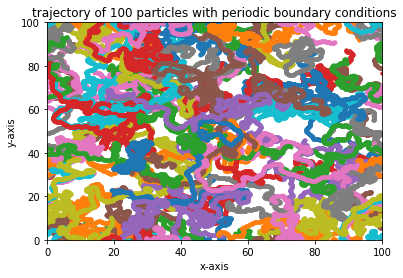

In [3]:
#figure
plt.plot(*np.transpose(viscekparticles(N,T,L,v_0,Dt,R,eta)[:,1:,:2], (2,0,1)),".")
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('trajectory of {} particles with periodic boundary conditions'.format(N))
plt.show()